<h1><center>ANALISIS KLASIFIKASI PERGERAKAN HARGA INDEKS REKSADANA BNI-AM MENGGUNAKAN RANDOM FOREST CLASSIFIER</center></h1>
<p><center><b>Kelompok 7</b><center>
<p><center><b>Adhelio Reyhandro (00000059870), Andreas Kendy Stevanus (00000061700),Fritz Filemon Siregar (00000060211), Gabriel Buffon Harahap (00000061688)
</b><center>
<p><center>Information System, Universitas Multimedia Nusantara, Tangerang, Indonesia<center>
<p><center>Email: adhelio.reyhandro@student.umn.ac.id<center>

___
## Essentials

### Mengabaikan Warning

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### Import Libraries

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

___
## Business Understanding

Melakukan klasifikasi naik turunnya harga saham dari perspektif bisnis sangat penting karena memberikan pergerakan harga pasar yang dapat membantu investor dalam mengambil keputusan investasi. Investor dapat membedakan tren pasar jangka pendek dan jangka panjang dengan mengkategorikan kenaikan dan penurunan nilai saham. Hal ini dapat memudahkan untuk memantau perubahan harga pasar. Dengan melakukan klasifikasi ini maka peluang investasi lebih potensial dengan memantau perubahan harga saham.

___
## Data Understanding

### Reading the dataset as a panda dataframe

In [3]:
df = pd.read_csv('STOCK_ID_XIDX_BBNI.csv')

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

df.tail(5)

,Open,High,Low,Close,Volume
Date,,,,,
1998-04-14,7709,8059,7358,7709,788447
1998-04-13,7709,8410,7709,7709,190994
1998-04-09,8059,8410,8059,8059,1018610
1998-04-08,8059,8410,8059,8059,393403
1998-04-06,8410,9111,8059,8410,2781574


### Exploring the dataset

In [4]:
df.shape

(6069, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6069 entries, 2023-05-05 to 1998-04-06
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Open    6069 non-null   int64
 1   High    6069 non-null   int64
 2   Low     6069 non-null   int64
 3   Close   6069 non-null   int64
 4   Volume  6069 non-null   int64
dtypes: int64(5)
memory usage: 284.5 KB


In [6]:
df.describe()

,Open,High,Low,Close,Volume
count,6069.000000,6069.000000,6069.000000,6069.000000,6.069000e+03
mean,4036.827484,4101.860109,3967.613281,4035.862086,1.954998e+07
std,2516.514271,2546.779451,2484.287027,2514.981511,2.620349e+07
min,384.000000,403.000000,374.000000,393.000000,3.600000e+01
25%,1673.000000,1697.000000,1645.000000,1673.000000,3.027930e+05
50%,3825.000000,3854.000000,3750.000000,3825.000000,1.429690e+07
75%,5650.000000,5725.000000,5550.000000,5625.000000,2.720110e+07
max,10175.000000,11914.000000,9900.000000,10175.000000,4.433385e+08


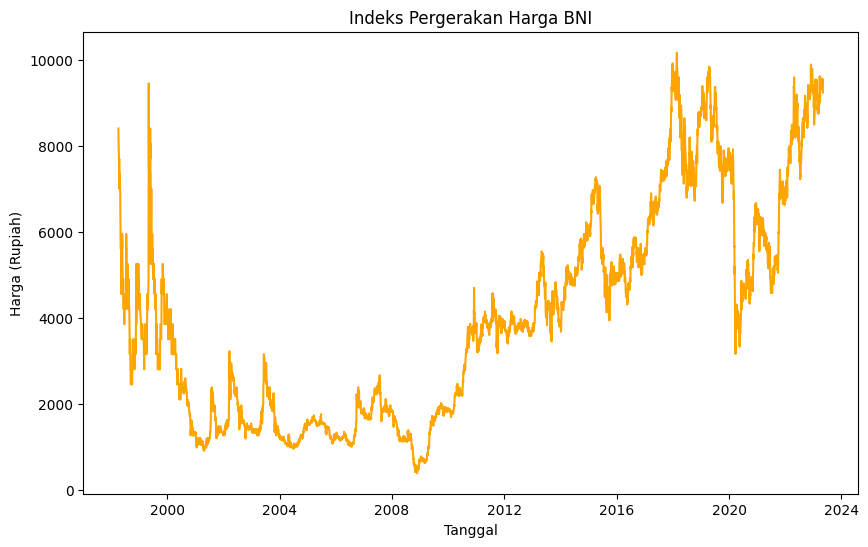

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], c='orange')
plt.title('Indeks Pergerakan Harga BNI')
plt.xlabel('Tanggal')
plt.ylabel('Harga (Rupiah)')
plt.show()

### Verifying dataset quality
#### Box plot for outliers visualization

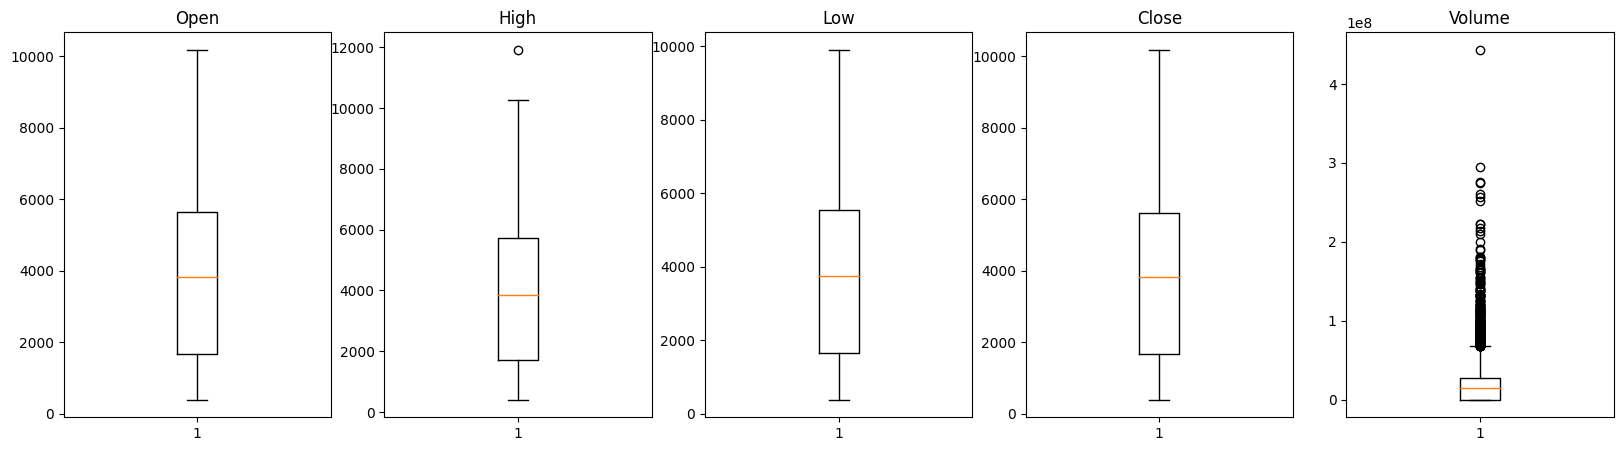

In [8]:
# Membuat subplot untuk setiap atribut
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

# Membuat boxplot untuk setiap atribut
axs[0].boxplot(df['Open'])
axs[0].set_title('Open')
axs[1].boxplot(df['High'])
axs[1].set_title('High')
axs[2].boxplot(df['Low'])
axs[2].set_title('Low')
axs[3].boxplot(df['Close'])
axs[3].set_title('Close')
axs[4].boxplot(df['Volume'])
axs[4].set_title('Volume')

# Menampilkan plot
plt.show()

___
## Data Preprocessing

### Cleaning the dataset
#### Removing the outliers with IQR method

In [9]:
print('Shape before outliers treatment', df.shape)

for i in df.columns:

    Q1 = df[i].quantile(q = .0)
    Q3 = df[i].quantile(q = .70)

    IQR = Q3 - Q1

    df[i] = df[i][-((df[i] < (Q1 - 1.5 * IQR)) | (df[i] > (Q3 + 1.5 * IQR)))]
    
df = df.dropna()

print('Shape after outliers treatment', df.shape)

Shape before outliers treatment (6069, 5)
Shape after outliers treatment (5717, 5)


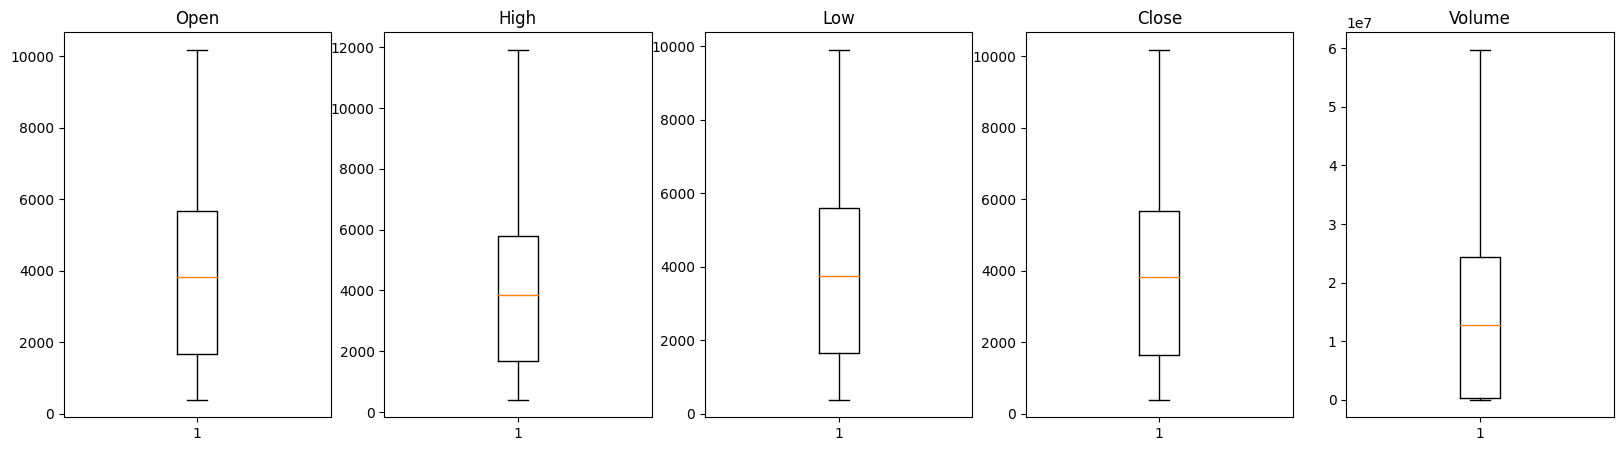

In [10]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

axs[0].boxplot(df['Open'])
axs[0].set_title('Open')
axs[1].boxplot(df['High'])
axs[1].set_title('High')
axs[2].boxplot(df['Low'])
axs[2].set_title('Low')
axs[3].boxplot(df['Close'])
axs[3].set_title('Close')
axs[4].boxplot(df['Volume'])
axs[4].set_title('Volume')

plt.show()

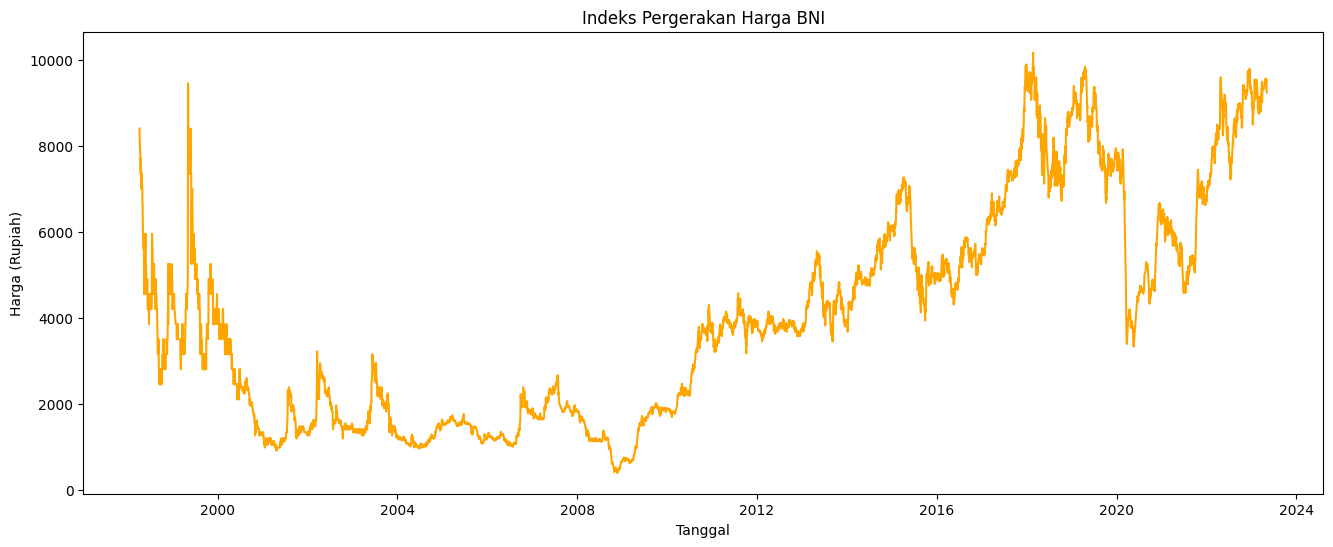

In [11]:
plt.figure(figsize=(16, 6))
plt.plot(df.index, df['Close'], c='orange')
plt.title('Indeks Pergerakan Harga BNI')
plt.xlabel('Tanggal')
plt.ylabel('Harga (Rupiah)')
plt.show()

### Feature Engineering
#### Creating features to support the model performance
Daily Returns for percentage change of closed price

In [12]:
df['Daily Returns'] = df['Close'][::-1].pct_change()
df.head(5)

,Open,High,Low,Close,Volume,Daily Returns
Date,,,,,,
2023-05-05,9300,9325,9150,9250,24618100.0,-0.005376
2023-05-04,9400,9425,9275,9300,20054301.0,-0.018470
2023-05-03,9550,9550,9400,9475,11944900.0,-0.007853
2023-05-02,9450,9550,9425,9550,19480301.0,0.013263
2023-04-28,9575,9575,9425,9425,23066400.0,-0.007895


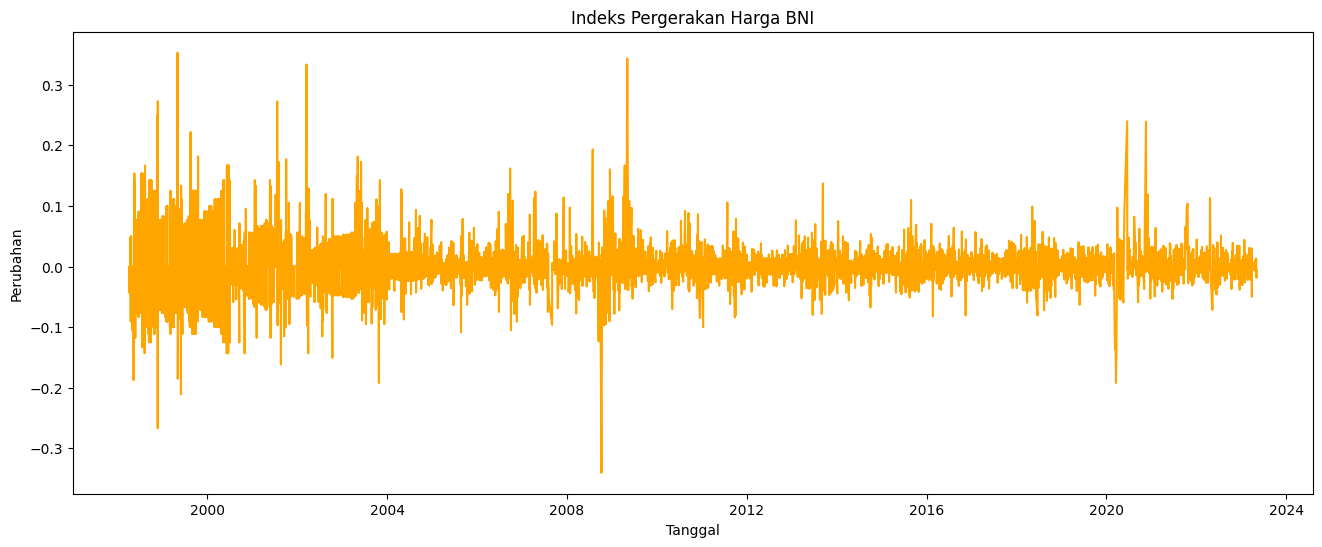

In [13]:
plt.figure(figsize=(16, 6))
plt.plot(df.index, df['Daily Returns'], c='orange')
plt.title('Indeks Pergerakan Harga BNI')
plt.xlabel('Tanggal')
plt.ylabel('Perubahan')
plt.show()

Relative Strength Index (RSI) for the momentum strength of price movements

In [14]:
delta = df['Close'][::-1].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))
df.head(5)

,Open,High,Low,Close,Volume,Daily Returns,RSI
Date,,,,,,,
2023-05-05,9300,9325,9150,9250,24618100.0,-0.005376,43.243243
2023-05-04,9400,9425,9275,9300,20054301.0,-0.018470,48.648649
2023-05-03,9550,9550,9400,9475,11944900.0,-0.007853,58.064516
2023-05-02,9450,9550,9425,9550,19480301.0,0.013263,64.285714
2023-04-28,9575,9575,9425,9425,23066400.0,-0.007895,56.521739


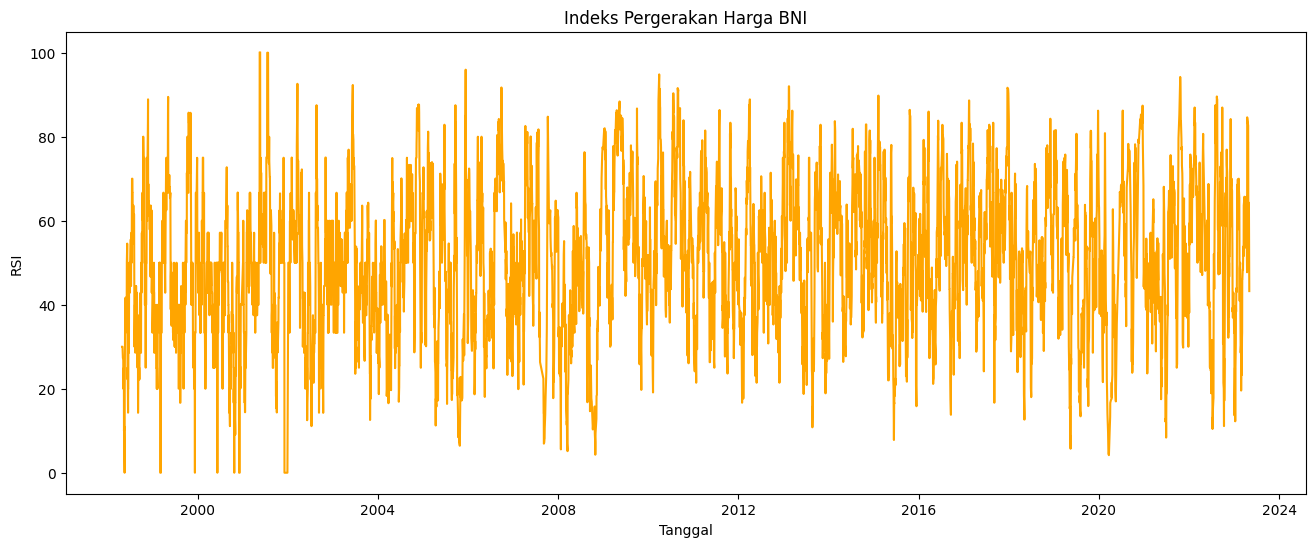

In [15]:
plt.figure(figsize=(16, 6))
plt.plot(df.index, df['RSI'], c='orange')
plt.title('Indeks Pergerakan Harga BNI')
plt.xlabel('Tanggal')
plt.ylabel('RSI')
plt.show()

Simple Moving Average (SMA) 20 days for bollinger bands

In [16]:
df['SMA_20'] = df['Close'][::-1].rolling(window=20).mean()
df.head(5)

,Open,High,Low,Close,Volume,Daily Returns,RSI,SMA_20
Date,,,,,,,,
2023-05-05,9300,9325,9150,9250,24618100.0,-0.005376,43.243243,9396.25
2023-05-04,9400,9425,9275,9300,20054301.0,-0.018470,48.648649,9393.75
2023-05-03,9550,9550,9400,9475,11944900.0,-0.007853,58.064516,9380.00
2023-05-02,9450,9550,9425,9550,19480301.0,0.013263,64.285714,9381.25
2023-04-28,9575,9575,9425,9425,23066400.0,-0.007895,56.521739,9365.00


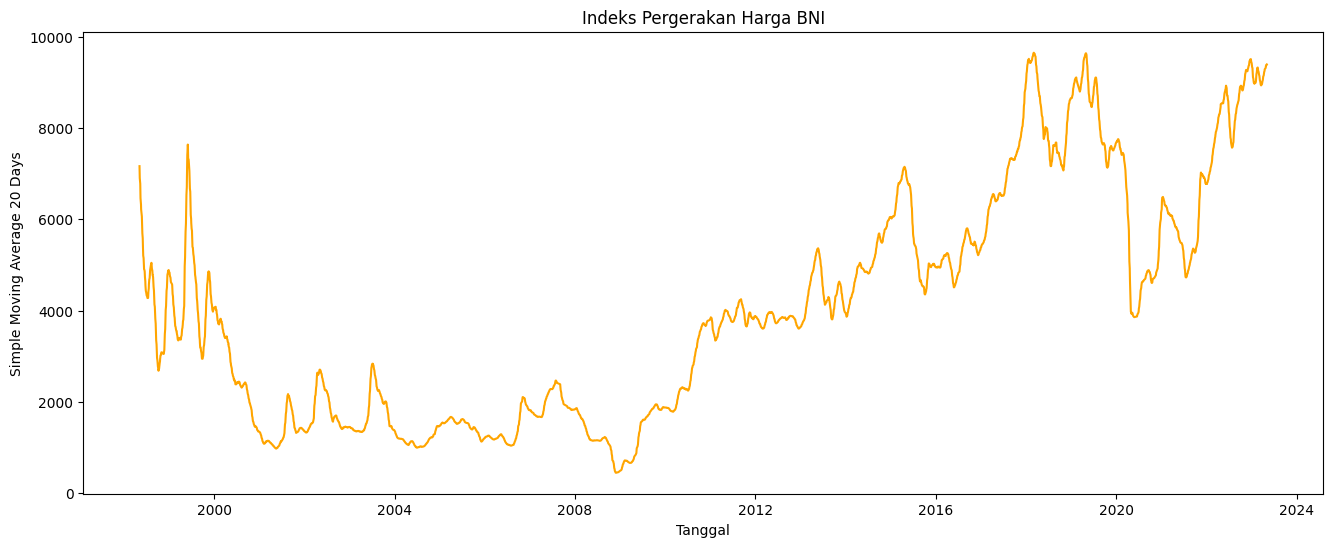

In [17]:
plt.figure(figsize=(16, 6))
plt.plot(df.index, df['SMA_20'], c='orange')
plt.title('Indeks Pergerakan Harga BNI')
plt.xlabel('Tanggal')
plt.ylabel('Simple Moving Average 20 Days')
plt.show()

Standard Deviation of 20 days

In [18]:
df['Std_dev'] = df['Close'][::-1].rolling(window=20).std()
df.head(5)

,Open,High,Low,Close,Volume,Daily Returns,RSI,SMA_20,Std_dev
Date,,,,,,,,,
2023-05-05,9300,9325,9150,9250,24618100.0,-0.005376,43.243243,9396.25,84.399972
2023-05-04,9400,9425,9275,9300,20054301.0,-0.018470,48.648649,9393.75,89.543800
2023-05-03,9550,9550,9400,9475,11944900.0,-0.007853,58.064516,9380.00,120.470569
2023-05-02,9450,9550,9425,9550,19480301.0,0.013263,64.285714,9381.25,121.632265
2023-04-28,9575,9575,9425,9425,23066400.0,-0.007895,56.521739,9365.00,119.593610


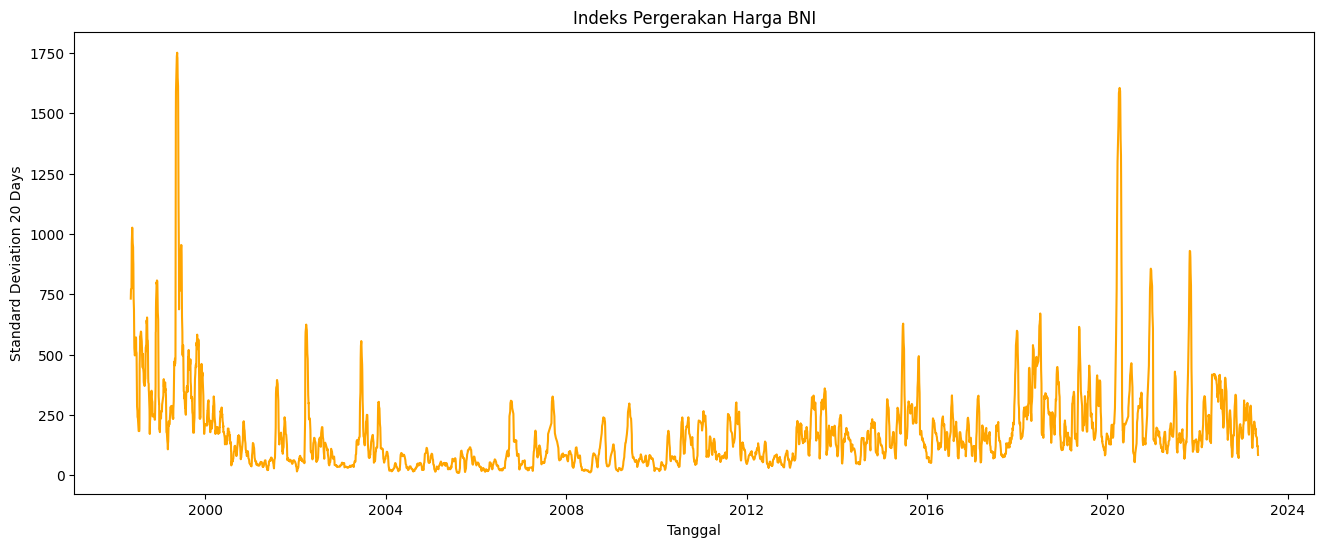

In [19]:
plt.figure(figsize=(16, 6))
plt.plot(df.index, df['Std_dev'], c='orange')
plt.title('Indeks Pergerakan Harga BNI')
plt.xlabel('Tanggal')
plt.ylabel('Standard Deviation 20 Days')
plt.show()

Bollinger Bands for volatility assessment

In [20]:
df['BB_top'] = df['SMA_20'] + df['Std_dev']
df['BB_bottom'] = df['SMA_20'] - df['Std_dev']
df.head(5)

,Open,High,Low,Close,Volume,Daily Returns,RSI,SMA_20,Std_dev,BB_top,BB_bottom
Date,,,,,,,,,,,
2023-05-05,9300,9325,9150,9250,24618100.0,-0.005376,43.243243,9396.25,84.399972,9480.649972,9311.850028
2023-05-04,9400,9425,9275,9300,20054301.0,-0.018470,48.648649,9393.75,89.543800,9483.293800,9304.206200
2023-05-03,9550,9550,9400,9475,11944900.0,-0.007853,58.064516,9380.00,120.470569,9500.470569,9259.529431
2023-05-02,9450,9550,9425,9550,19480301.0,0.013263,64.285714,9381.25,121.632265,9502.882265,9259.617735
2023-04-28,9575,9575,9425,9425,23066400.0,-0.007895,56.521739,9365.00,119.593610,9484.593610,9245.406390


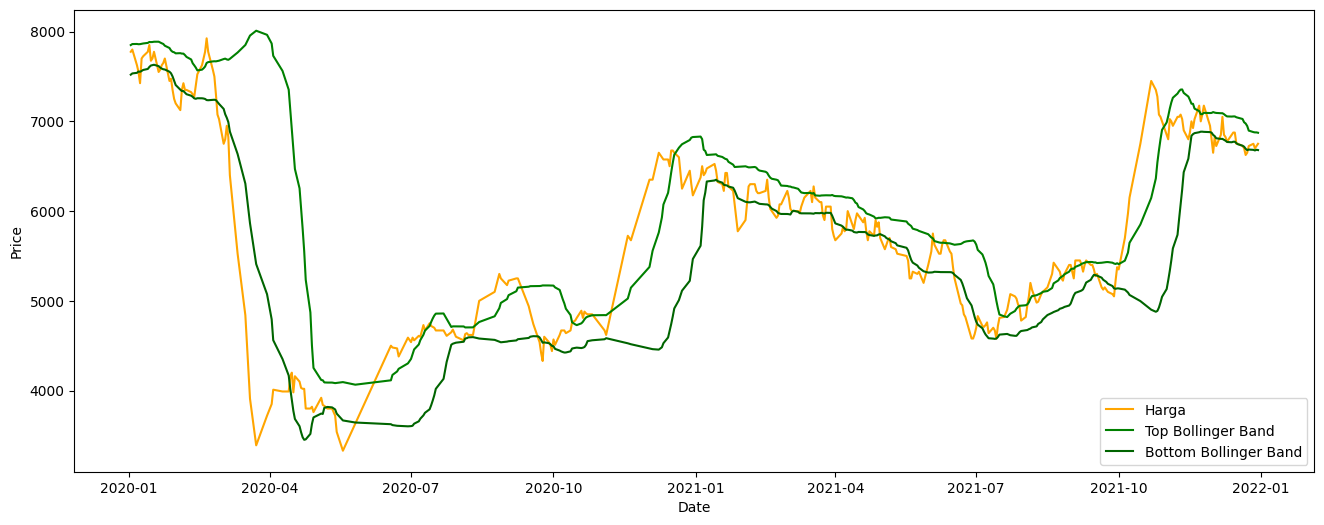

In [21]:
plt.figure(figsize=(16, 6))

plt.plot(df['2020':'2021']['Close'], label='Harga', c='orange')
plt.plot(df['2020':'2021']['BB_top'], label='Top Bollinger Band', c='green')
plt.plot(df['2020':'2021']['BB_bottom'], label='Bottom Bollinger Band', c='darkgreen')

plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

#### Creating data lag for the classification model

In [22]:
df['Open_t-20'] = df['Open'].shift(-20)
df['High_t-20'] = df['High'].shift(-20)
df['Low_t-20'] = df['Low'].shift(-20)
df['Close_t-20'] = df['Close'].shift(-20)
df.tail(6)

,Open,High,Low,Close,Volume,Daily Returns,RSI,SMA_20,Std_dev,BB_top,BB_bottom,Open_t-20,High_t-20,Low_t-20,Close_t-20
Date,,,,,,,,,,,,,,,
1998-04-15,7358,7709,7358,7358,85687.0,-0.045531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-04-14,7709,8059,7358,7709,788447.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-04-13,7709,8410,7709,7709,190994.0,-0.043430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-04-09,8059,8410,8059,8059,1018610.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-04-08,8059,8410,8059,8059,393403.0,-0.041736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-04-06,8410,9111,8059,8410,2781574.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
df['Volume_t-20'] = df['Volume'].shift(-20)
df.tail(6)

,Open,High,Low,Close,Volume,Daily Returns,RSI,SMA_20,Std_dev,BB_top,BB_bottom,Open_t-20,High_t-20,Low_t-20,Close_t-20,Volume_t-20
Date,,,,,,,,,,,,,,,,
1998-04-15,7358,7709,7358,7358,85687.0,-0.045531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-04-14,7709,8059,7358,7709,788447.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-04-13,7709,8410,7709,7709,190994.0,-0.043430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-04-09,8059,8410,8059,8059,1018610.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-04-08,8059,8410,8059,8059,393403.0,-0.041736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-04-06,8410,9111,8059,8410,2781574.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df['DR_t-20'] = df['Daily Returns'].shift(-20)
df.head(6)

,Open,High,Low,Close,Volume,Daily Returns,RSI,SMA_20,Std_dev,BB_top,BB_bottom,Open_t-20,High_t-20,Low_t-20,Close_t-20,Volume_t-20,DR_t-20
Date,,,,,,,,,,,,,,,,,
2023-05-05,9300,9325,9150,9250,24618100.0,-0.005376,43.243243,9396.25,84.399972,9480.649972,9311.850028,9050.0,9250.0,9025.0,9200.0,28914400.0,0.019391
2023-05-04,9400,9425,9275,9300,20054301.0,-0.018470,48.648649,9393.75,89.543800,9483.293800,9304.206200,9200.0,9200.0,9000.0,9025.0,36436699.0,-0.050000
2023-05-03,9550,9550,9400,9475,11944900.0,-0.007853,58.064516,9380.00,120.470569,9500.470569,9259.529431,9675.0,9750.0,9500.0,9500.0,55198801.0,0.029810
2023-05-02,9450,9550,9425,9550,19480301.0,0.013263,64.285714,9381.25,121.632265,9502.882265,9259.617735,9050.0,9250.0,8975.0,9225.0,22471900.0,0.025000
2023-04-28,9575,9575,9425,9425,23066400.0,-0.007895,56.521739,9365.00,119.593610,9484.593610,9245.406390,9025.0,9125.0,8975.0,9000.0,16098900.0,-0.002770
2023-04-27,9550,9600,9475,9500,15352900.0,-0.007833,65.000000,9343.75,143.699934,9487.449934,9200.050066,9000.0,9150.0,8975.0,9025.0,59214000.0,0.008380


In [25]:
df['RSI_t-20'] = df['RSI'].shift(-20)
df.tail(6)

,Open,High,Low,Close,Volume,Daily Returns,RSI,SMA_20,Std_dev,BB_top,BB_bottom,Open_t-20,High_t-20,Low_t-20,Close_t-20,Volume_t-20,DR_t-20,RSI_t-20
Date,,,,,,,,,,,,,,,,,,
1998-04-15,7358,7709,7358,7358,85687.0,-0.045531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-04-14,7709,8059,7358,7709,788447.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-04-13,7709,8410,7709,7709,190994.0,-0.043430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-04-09,8059,8410,8059,8059,1018610.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-04-08,8059,8410,8059,8059,393403.0,-0.041736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-04-06,8410,9111,8059,8410,2781574.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
df['Std_dev_t-20'] = df['Std_dev'].shift(-20)
df.tail(6)

,Open,High,Low,Close,Volume,Daily Returns,RSI,SMA_20,Std_dev,BB_top,BB_bottom,Open_t-20,High_t-20,Low_t-20,Close_t-20,Volume_t-20,DR_t-20,RSI_t-20,Std_dev_t-20
Date,,,,,,,,,,,,,,,,,,,
1998-04-15,7358,7709,7358,7358,85687.0,-0.045531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-04-14,7709,8059,7358,7709,788447.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-04-13,7709,8410,7709,7709,190994.0,-0.043430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-04-09,8059,8410,8059,8059,1018610.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-04-08,8059,8410,8059,8059,393403.0,-0.041736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-04-06,8410,9111,8059,8410,2781574.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
df['BB_top_t-20'] = df['BB_top'].shift(-20)
df.tail(6)

,Open,High,Low,Close,Volume,Daily Returns,RSI,SMA_20,Std_dev,BB_top,BB_bottom,Open_t-20,High_t-20,Low_t-20,Close_t-20,Volume_t-20,DR_t-20,RSI_t-20,Std_dev_t-20,BB_top_t-20
Date,,,,,,,,,,,,,,,,,,,,
1998-04-15,7358,7709,7358,7358,85687.0,-0.045531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-04-14,7709,8059,7358,7709,788447.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-04-13,7709,8410,7709,7709,190994.0,-0.043430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-04-09,8059,8410,8059,8059,1018610.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-04-08,8059,8410,8059,8059,393403.0,-0.041736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-04-06,8410,9111,8059,8410,2781574.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
df['BB_bottom_t-20'] = df['BB_bottom'].shift(-20)
df.tail(6)

,Open,High,Low,Close,Volume,Daily Returns,RSI,SMA_20,Std_dev,BB_top,...,Open_t-20,High_t-20,Low_t-20,Close_t-20,Volume_t-20,DR_t-20,RSI_t-20,Std_dev_t-20,BB_top_t-20,BB_bottom_t-20
Date,,,,,,,,,,,,,,,,,,,,,
1998-04-15,7358,7709,7358,7358,85687.0,-0.045531,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-04-14,7709,8059,7358,7709,788447.0,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-04-13,7709,8410,7709,7709,190994.0,-0.043430,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-04-09,8059,8410,8059,8059,1018610.0,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-04-08,8059,8410,8059,8059,393403.0,-0.041736,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-04-06,8410,9111,8059,8410,2781574.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Creating the target variable
1 means the price goes up, and 0 means the price goes down or stagnant

In [29]:
df['y'] = np.where(df['Close'].shift(-1) > df['Close'], 0, 1)
df.head(6)

,Open,High,Low,Close,Volume,Daily Returns,RSI,SMA_20,Std_dev,BB_top,...,High_t-20,Low_t-20,Close_t-20,Volume_t-20,DR_t-20,RSI_t-20,Std_dev_t-20,BB_top_t-20,BB_bottom_t-20,y
Date,,,,,,,,,,,,,,,,,,,,,
2023-05-05,9300,9325,9150,9250,24618100.0,-0.005376,43.243243,9396.25,84.399972,9480.649972,...,9250.0,9025.0,9200.0,28914400.0,0.019391,60.227273,179.413335,9163.163335,8804.336665,0
2023-05-04,9400,9425,9275,9300,20054301.0,-0.018470,48.648649,9393.75,89.543800,9483.293800,...,9200.0,9000.0,9025.0,36436699.0,-0.050000,53.488372,172.114367,9143.364367,8799.135633,0
2023-05-03,9550,9550,9400,9475,11944900.0,-0.007853,58.064516,9380.00,120.470569,9500.470569,...,9750.0,9500.0,9500.0,55198801.0,0.029810,65.714286,173.679226,9136.179226,8788.820774,0
2023-05-02,9450,9550,9425,9550,19480301.0,0.013263,64.285714,9381.25,121.632265,9502.882265,...,9250.0,8975.0,9225.0,22471900.0,0.025000,63.636364,121.774165,9061.774165,8818.225835,1
2023-04-28,9575,9575,9425,9425,23066400.0,-0.007895,56.521739,9365.00,119.593610,9484.593610,...,9125.0,8975.0,9000.0,16098900.0,-0.002770,51.562500,113.402810,9049.652810,8822.847190,0
2023-04-27,9550,9600,9475,9500,15352900.0,-0.007833,65.000000,9343.75,143.699934,9487.449934,...,9150.0,8975.0,9025.0,59214000.0,0.008380,53.846154,135.966327,9085.966327,8814.033673,0


#### Removing missing values caused by new features creation

In [30]:
print(df.isnull().sum().sum())
print(df.shape)

363
(5717, 22)


In [31]:
df = df.dropna()

print(df.isnull().sum().sum())
print(df.shape)

0
(5676, 22)


___
## Modelling

#### Reversing the index by date

In [32]:
df = df[::-1]

#### Splitting the dataframe

In [33]:
X = df.iloc[:,12:-1]
y = df['y']
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5676 entries, 1998-06-09 to 2023-05-05
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   High_t-20       5676 non-null   float64
 1   Low_t-20        5676 non-null   float64
 2   Close_t-20      5676 non-null   float64
 3   Volume_t-20     5676 non-null   float64
 4   DR_t-20         5676 non-null   float64
 5   RSI_t-20        5676 non-null   float64
 6   Std_dev_t-20    5676 non-null   float64
 7   BB_top_t-20     5676 non-null   float64
 8   BB_bottom_t-20  5676 non-null   float64
dtypes: float64(9)
memory usage: 443.4 KB


#### Time series splitting the splitted dataframe

In [34]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 5, test_size=365*2, gap=2)
df.sort_index()

tss

TimeSeriesSplit(gap=2, max_train_size=None, n_splits=5, test_size=730)

creating a backup of the dataframe

In [35]:
df_bak = df.copy()

#### Visualizing the train and test dataframe

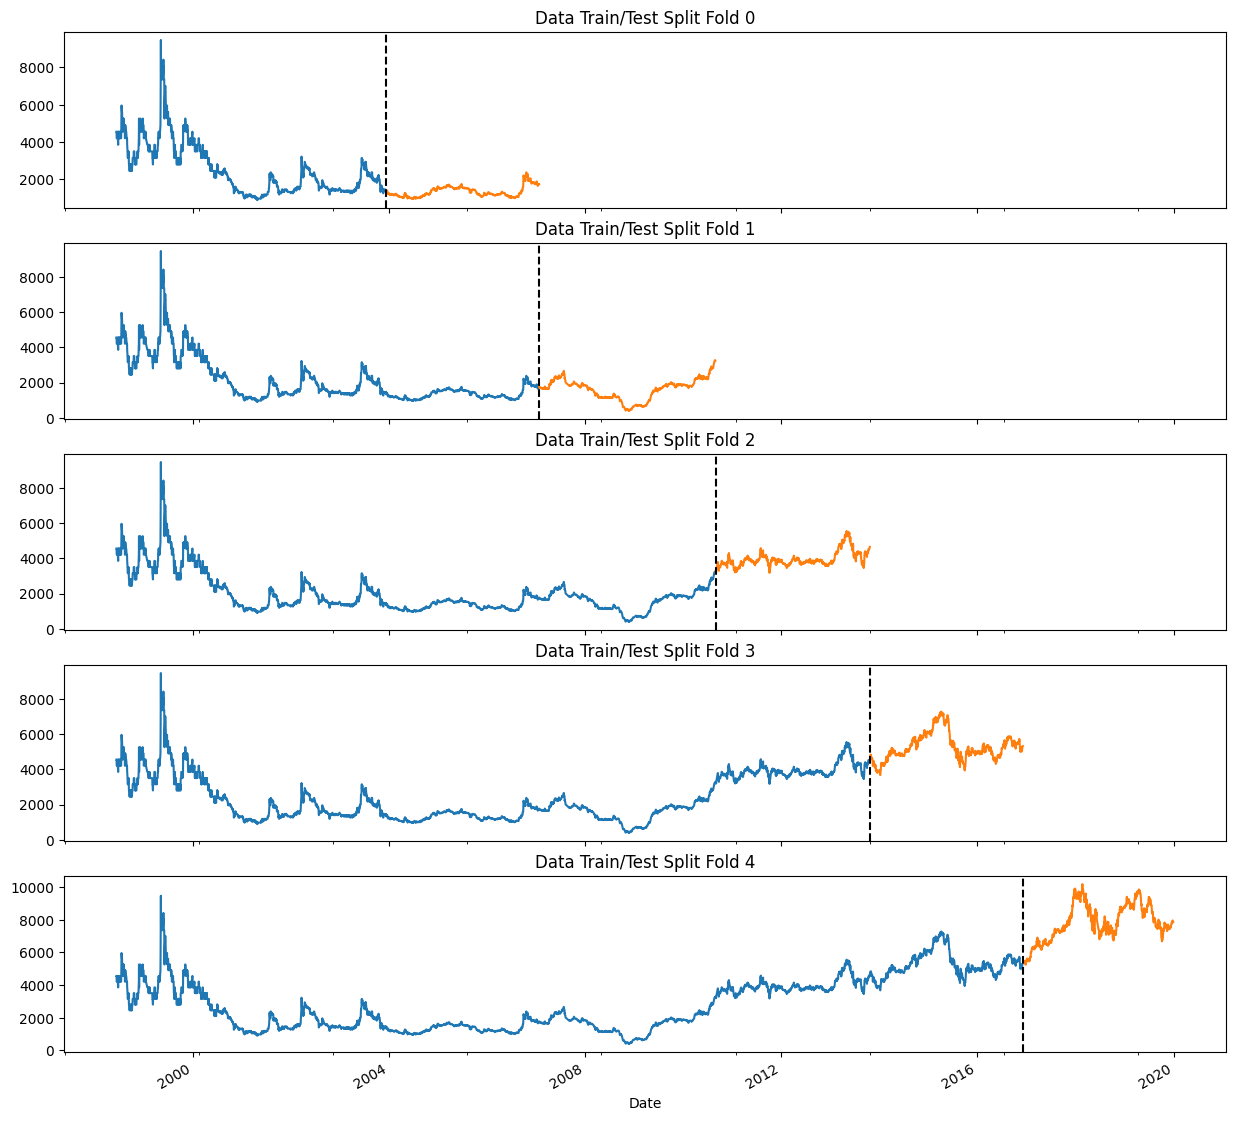

In [36]:
df = df_bak['1998':'2019']

fig, axs = plt.subplots(5, 1, figsize=(15, 15),
                              sharex=True)

fold = 0

for train_index, test_index in tss.split(df):
        
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    train = df.iloc[train_index]
    test = df.iloc[test_index]
    
    train['Close'].plot(ax=axs[fold],
                                label='Training Set',
                                title=f'Data Train/Test Split Fold {fold}')
    
    test['Close'].plot(ax=axs[fold],
                         label='Test Set')
    
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

#### Pre pruning
Hyperparameter tuning the Random Forest Classifier

In [37]:
start_time = time.time()

param_grid = {
    'criterion':['entropy'],
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 50],
    'max_leaf_nodes': [10, 20, 30],
    'random_state': [0]
}

rfc = RandomForestClassifier()

grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=tss)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
cv_results = grid_search.cv_results_

# ---

end_time = time.time()
elapsed_time = end_time - start_time

seconds = elapsed_time % 60
minutes = (elapsed_time // 60) % 60
hours = elapsed_time // 3600

print(f"Elapsed Time: {hours:.0f} hours, {minutes:.0f} minutes, {seconds:.2f} seconds")

Elapsed Time: 0 hours, 1 minutes, 44.74 seconds


In [38]:
scores = cv_results['mean_test_score']

results_df = pd.DataFrame(cv_results['params'])
results_df['Score'] = scores

results_df = results_df.sort_values(by='Score', ascending=False).reset_index(drop=True)

results_df['Rank'] = results_df.index + 1

#### Printing rankings of the parameters

In [39]:
para_frame = results_df[['Rank'] + list(results_df.columns[:-1])]
para_frame[:10]

,Rank,criterion,max_depth,max_leaf_nodes,n_estimators,random_state,Score
0,1,entropy,50,20,50,0,0.620000
1,2,entropy,20,20,50,0,0.620000
2,3,entropy,20,10,150,0,0.618630
3,4,entropy,10,10,150,0,0.618630
4,5,entropy,50,10,150,0,0.618630
5,6,entropy,10,20,50,0,0.618356
6,7,entropy,10,20,100,0,0.618082
7,8,entropy,20,30,100,0,0.617808
8,9,entropy,50,30,100,0,0.617808
9,10,entropy,20,10,100,0,0.616986


#### Training the model

In [40]:
tss = TimeSeriesSplit(n_splits=5, test_size=365*2, gap=2)
df = df.sort_index()


fold = 0

for train_index, test_index in tss.split(df):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    rfc = RandomForestClassifier(**best_params)
    
    rfc.fit(X_train, y_train)

    y_pred = rfc.predict(X_test)
    
    score = accuracy_score(y_test, y_pred)

    print(f"Fold {fold} Accuracy score: {score:.3f}")
    fold += 1

Fold 0 Accuracy score: 0.629
Fold 1 Accuracy score: 0.579
Fold 2 Accuracy score: 0.607
Fold 3 Accuracy score: 0.568
Fold 4 Accuracy score: 0.497


___
## Evaluation

### Evaluating the model
#### Plotting the important features

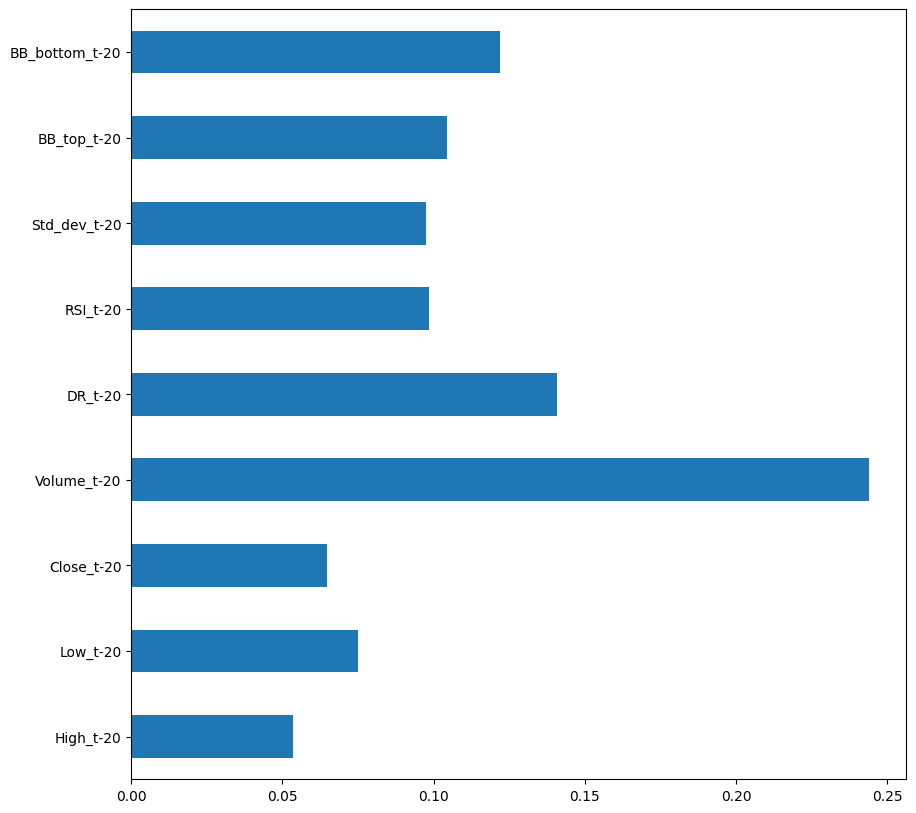

In [41]:
plt.figure(figsize=(10, 10))
feat_importances = pd.Series(rfc.feature_importances_, index=X.columns)
feat_importances.plot(kind='barh')
plt.show()

#### Plotting the confusion matrix

Text(77.92222222222227, 0.5, 'predicted label')

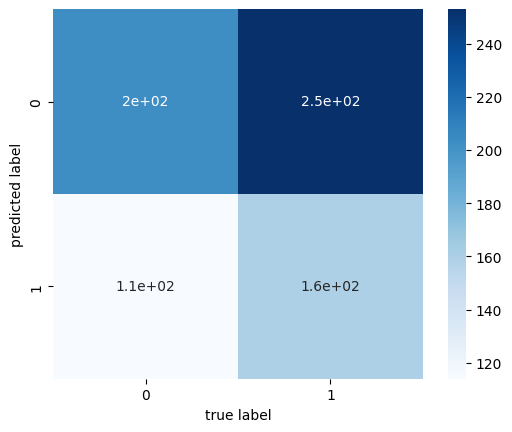

In [42]:
y_pred = rfc.predict(X_test)

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square = True, annot = True, cmap ='Blues')
plt.xlabel('true label')
plt.ylabel('predicted label')

#### Print the accuracy of train and test set

In [43]:
print('Accuracy of Random Forest classifier on training set: {:.3f}'.format(rfc.score(X_train, y_train)))
print('Accuracy of Random Forest classifier on test set: {:.3f}'.format(rfc.score(X_test, y_test)))

Accuracy of Random Forest classifier on training set: 0.654
Accuracy of Random Forest classifier on test set: 0.497


#### Plotting one of the estimator tree

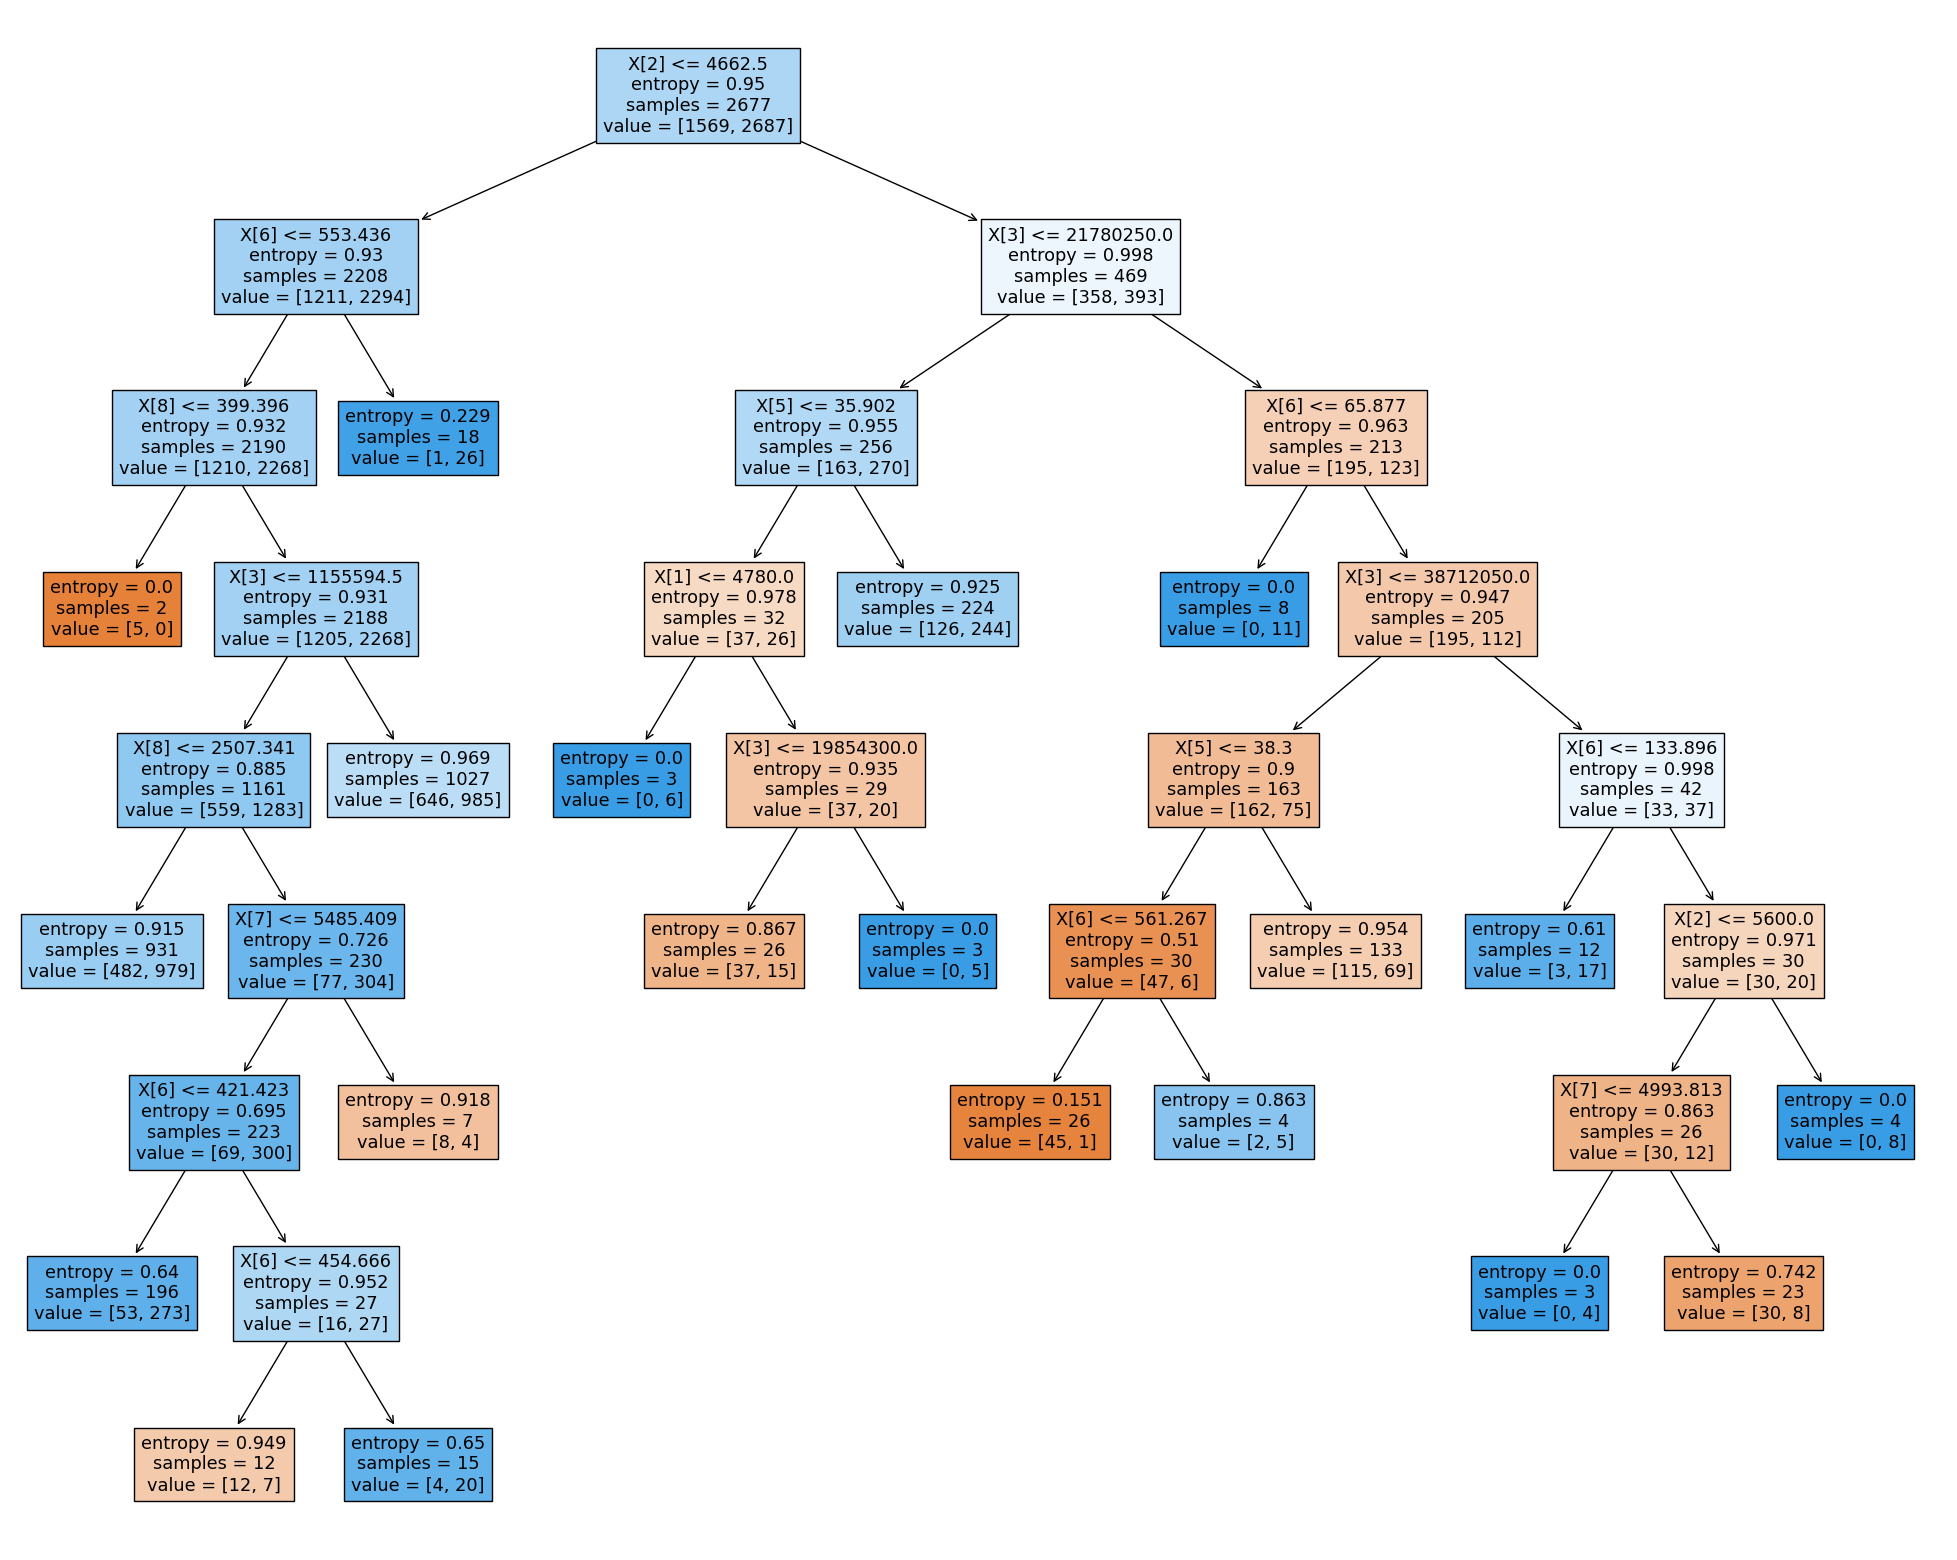

In [44]:
fig = plt.figure(figsize=(25,20))
tree.plot_tree(rfc.estimators_[0],filled=True)
plt.show()

#### Printing the classification reports

In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.64      0.53       317
           1       0.58      0.39      0.47       413

    accuracy                           0.50       730
   macro avg       0.51      0.51      0.50       730
weighted avg       0.52      0.50      0.49       730



#### Printing the precision, recall, and F1 scores

In [46]:
# Calculate precision
print('Precision     : {:.3f}'.format(precision_score(y_test, y_pred)))
# Calculate recall
print('Recall        : {:.3f}'.format(recall_score(y_test, y_pred)))
# Calculate F1 score
print('F1-Score      : {:.3f}'.format(f1_score(y_test, y_pred)))

Precision     : 0.584
Recall        : 0.387
F1-Score      : 0.466


#### Retrain the model using the best features

In [47]:
X = df.iloc[:,15:-1]
y = df['y']
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4988 entries, 1998-06-09 to 2019-12-30
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Volume_t-20     4988 non-null   float64
 1   DR_t-20         4988 non-null   float64
 2   RSI_t-20        4988 non-null   float64
 3   Std_dev_t-20    4988 non-null   float64
 4   BB_top_t-20     4988 non-null   float64
 5   BB_bottom_t-20  4988 non-null   float64
dtypes: float64(6)
memory usage: 272.8 KB


In [48]:
tss = TimeSeriesSplit(n_splits=5, test_size=365*2, gap=2)
df = df.sort_index()


fold = 0
preds = []
scores = []

for train_index, test_index in tss.split(df):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    rfc = RandomForestClassifier(**best_params)
    
    rfc.fit(X_train, y_train)

    y_pred = rfc.predict(X_test)
    
    preds.append(y_pred)
    
    score = accuracy_score(y_test, y_pred)
    scores.append(score)
    print(f"Fold {fold} Accuracy score: {score:.3f}")
    fold += 1

Fold 0 Accuracy score: 0.629
Fold 1 Accuracy score: 0.577
Fold 2 Accuracy score: 0.607
Fold 3 Accuracy score: 0.548
Fold 4 Accuracy score: 0.500


#### Plotting the important features on new model

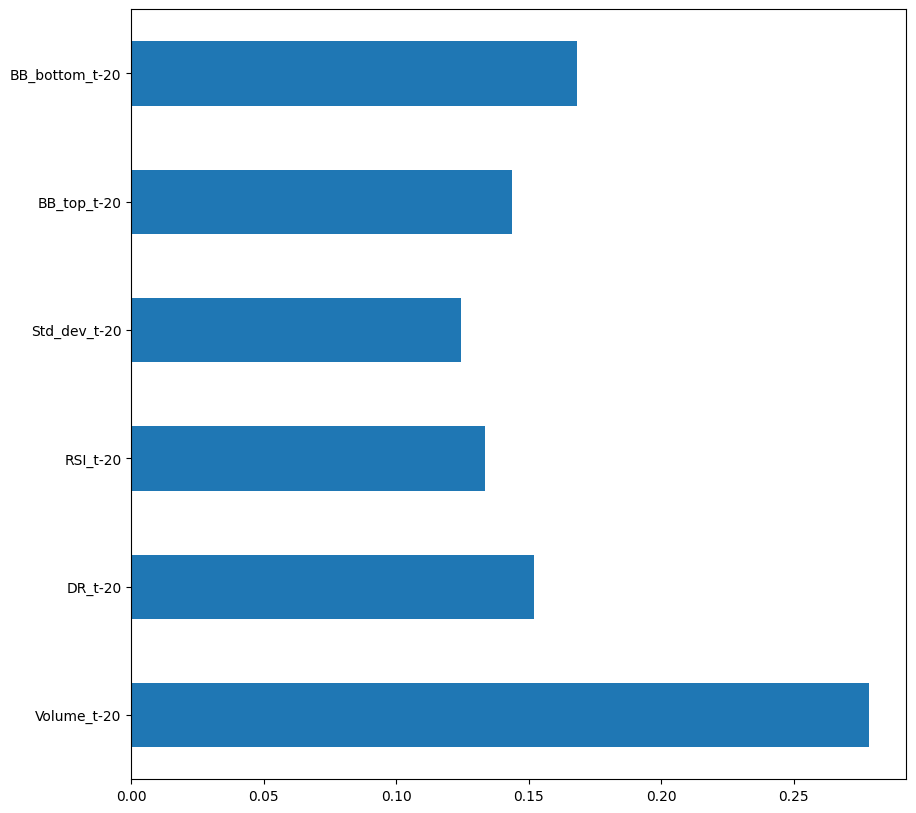

In [49]:
plt.figure(figsize=(10, 10))
feat_importances = pd.Series(rfc.feature_importances_, index=X.columns)
feat_importances.plot(kind='barh')
plt.show()

#### Plotting the confusion matrix on new model

Text(77.92222222222227, 0.5, 'predicted label')

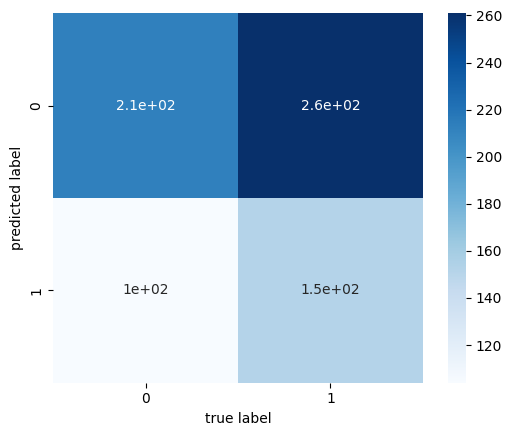

In [50]:
y_pred = rfc.predict(X_test)

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square = True, annot = True, cmap ='Blues')
plt.xlabel('true label')
plt.ylabel('predicted label')

#### Print the accuracy of train and test set on new model

In [51]:
print('Accuracy of Random Forest classifier on training set: {:.3f}'.format(rfc.score(X_train, y_train)))
print('Accuracy of Random Forest classifier on test set: {:.3f}'.format(rfc.score(X_test, y_test)))

Accuracy of Random Forest classifier on training set: 0.650
Accuracy of Random Forest classifier on test set: 0.500


#### Plotting one of the estimator tree on new model

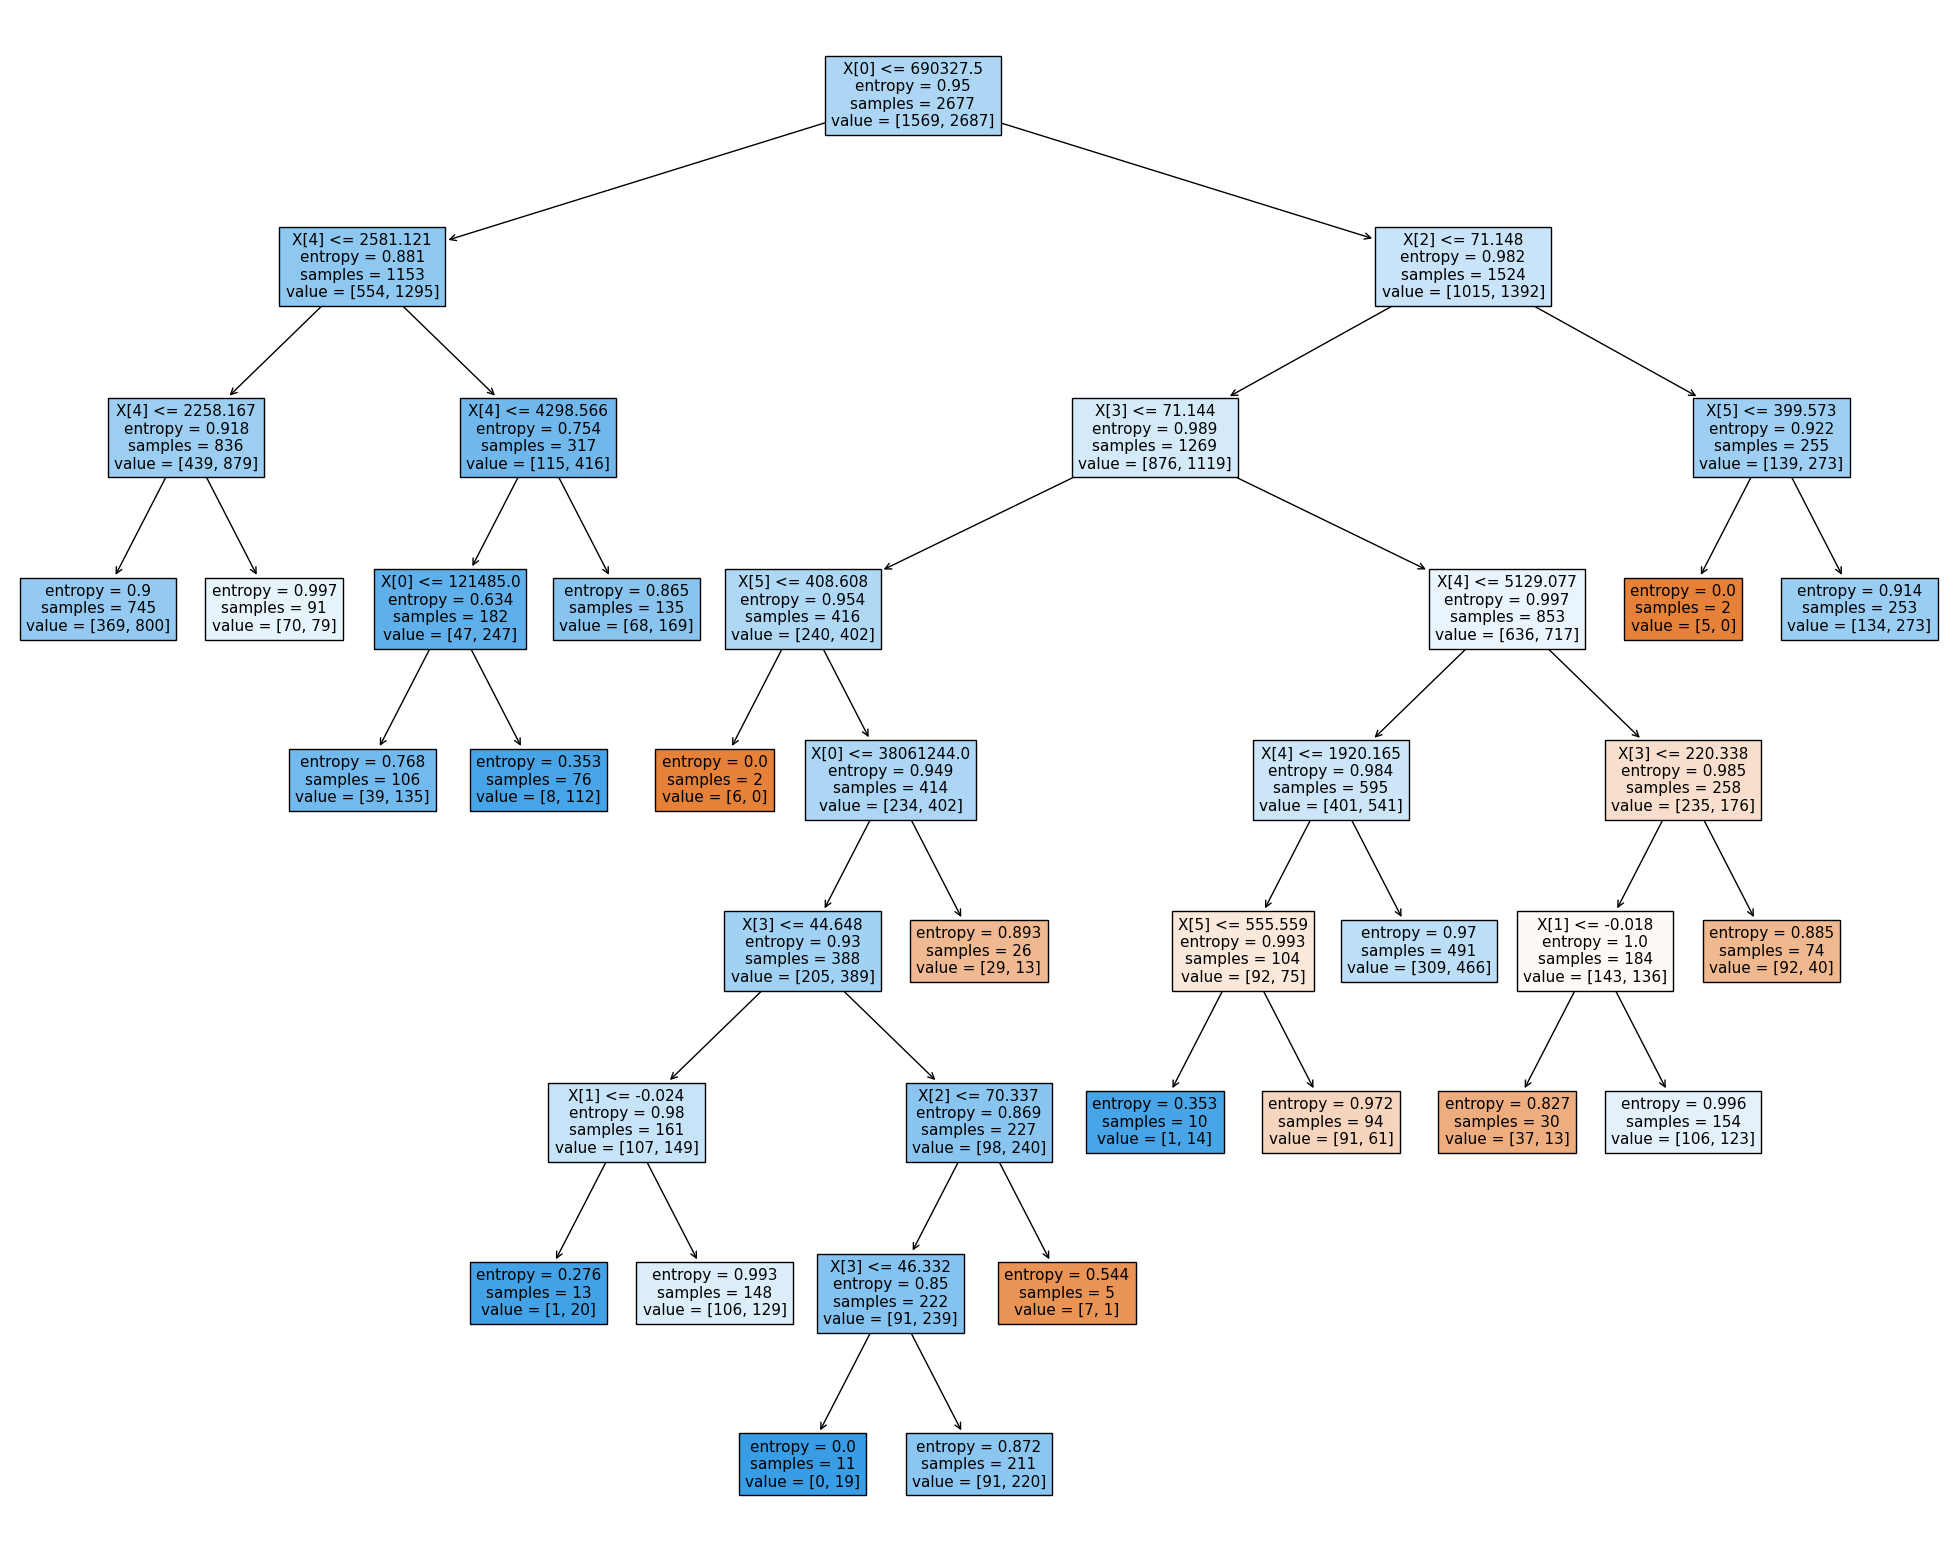

In [56]:
fig = plt.figure(figsize=(25,20))
tree.plot_tree(rfc.estimators_[0],filled=True)
plt.show()

#### Printing the classification reports on new model

In [53]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.67      0.54       317
           1       0.59      0.37      0.45       413

    accuracy                           0.50       730
   macro avg       0.52      0.52      0.50       730
weighted avg       0.53      0.50      0.49       730



#### Printing the precision, recall, F1, and scores on new model

In [54]:
# Calculate precision
print('Precision     : {:.3f}'.format(precision_score(y_test, y_pred)))
# Calculate recall
print('Recall        : {:.3f}'.format(recall_score(y_test, y_pred)))
# Calculate F1 score
print('F1-Score      : {:.3f}'.format(f1_score(y_test, y_pred)))

Precision     : 0.594
Recall        : 0.368
F1-Score      : 0.454


___
### Kesimpulan

Kesimpulan yang didapat dari analisis klasifikasi pergerakan harga indeks reksadana BNI-AM dengan Random Forest Classifier adalah pembuatan fitur-fitur baru untuk mendukung model dalam klasifikasi harga masa depan diperlukan demi meningkatkan performa model. Fitur-fitur yang diciptakan merupakan persentase perubahan harga, RSI, Standar deviasi 20 hari, Bollinger bands 20 hari. Dari semua fitur yang diuji pada penelitian ini, volume dan daily returns h-20 memiliki pengaruh terbesar untuk model. Model menghasilkan bentuk yang tidak over fit dengan hasil akurasi model yang didapat tidak terlalu baik, dimana hal ini terjadi karena pergerakan harga saham tidak selalu memiliki pola yang sama. Berbeda dengan jenis data lainnya, dimana semakin banyak data akan semakin akurat model saat dilatih. Dibutuhkan berbagai data eksternal, seperti sentimen berita terhadap saham BNI, selain hanya menggunakan data pergerakan harga dan volume untuk meningkatkan performa model dalam mengklasifikasi pergerakan harga.

___